# Community Detection: Newman's Fast Algorithm´´
**rn222qf**
The **network** groups of nodes (vertices) connected by edges (links). Where the groups of nodes knowns as **communities** e.g. **Social networks**: Friend groups, family circles, work colleagues.  
We detect communities to discover hidden structure and predict network behaviors, find important groups as well as help users understand the structue by visulaze the result. 

Earlier, people used the `Girvan-Newman algorithm (2002)` to detect communities. It worked well, but it was very slow. *For a network with 56,000 nodes, it could take 3–5 YEARS to finish.*

That’s why in 2004, *Mark Newman* came up with `Newman's Fast Algorithm` that is much faster. *Same network → only 42 minutes* 

This faster version is what we use in this assignment. on three input files 
- three_communities.edgelist
- karate.edgelist
- les_miserables.edgelist

To detect communites I will use *greedy approch* which means **at every iteration we take the `highest ΔQ`, hoping it lead to a good global solution**

- 0.3-0.7 < Q significant structure

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_graph(file_path):
    G = nx.read_edgelist(file_path, nodetype=str)
    mapping = {node: i for i, node in enumerate(G.nodes())}
    inv_mapping = {i: node for node, i in mapping.items()}
    
    graph = nx.relabel_nodes(G, mapping)
    
    print(f"Loaded graph from: {file_path}")

    print(f" Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f" Density: {nx.density(graph):.4f}")
    
    return graph, inv_mapping

In [3]:
def e_ij_matrix(G):
    
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    e = np.zeros((n, n))
    for u, v in G.edges():
        e[u, v] += 1 / (2 * m)
        e[v, u] += 1 / (2 * m)
    
    print(f"\n Initial e matrix ({n}×{n}):")
    print(f"   Each edge contributes 1/(2m) = 1/{2*m} = {1/(2*m):.6f}")
    print(f"   Diagonal: ")
    print(f"   Matrix sum: {e.sum():.6f}")
        
    return e

## Calculate modularity Q = Σ(e_ii - a_i^2)


In [4]:
def calculate_modularity(e):
    a = np.sum(e, axis=1) 
    Q = np.sum(np.diag(e) - a**2)

    print("\n Modularity Q")
    print(f"   Internal edges: {np.sum(np.diag(e)):.4f}")
    print(f"   Expected:       {np.sum(a**2):.4f}")
    print(f" ->  Q = {Q:.6f}")

    return Q


In [5]:
def newman_fast_algorithm(G, k):
    n = G.number_of_nodes()
    communities = {i: [i] for i in range(n)}
    e = e_ij_matrix(G)
    
    community_members = list(communities.values())

    history = []  
    
    print(f"Initial e sum: {e.sum():.6f}")  # 1.0
    
    step = 0
    while len(community_members) > k:
        step += 1
        a = np.sum(e, axis=1)
        dq = 2 * (e - np.outer(a, a))
        np.fill_diagonal(dq, -np.inf)
        i, j = np.unravel_index(np.argmax(dq), dq.shape)

        old_e_ii = e[i, i]
        old_e_jj = e[j, j]
        old_e_ij = e[i, j]
        old_e_ji = e[j, i]
        
        new_e_ii = old_e_ii + old_e_jj + old_e_ij + old_e_ji
        
        community_members[i].extend(community_members[j])
        del community_members[j]

        # Update e_matrix
        e[i, :] = e[i, :] + e[j, :]
        e[:, i] = e[:, i] + e[j, :]  
        e[i, i] = new_e_ii
        
        e = np.delete(e, j, axis=0)
        e = np.delete(e, j, axis=1)
        
        current_a = np.sum(e, axis=1)
        current_Q = np.sum(np.diag(e) - current_a**2)
        history.append((current_Q, len(community_members)))  
        
        if step % 10 == 0 or len(community_members) <= 5:
            print(f"Step {step}: {len(community_members)} communities, Q={current_Q:.4f}, e_sum={e.sum():.6f}")
    
    # Final Q
    a = np.sum(e, axis=1)
    Q = np.sum(np.diag(e) - a**2)
    
    print(f"\nFinal diagnostics:")
    print(f"  e matrix shape: {e.shape}")
    print(f"  e matrix sum: {e.sum():.6f}")
    print(f"  e diagonal: {np.diag(e)}")
    print(f"  a values: {a}")
    print(f"  a^2: {a**2}")
    print(f"  e_ii - a^2: {np.diag(e) - a**2}")
    print(f"  Final Q: {Q:.10f}")
    
    return Q, community_members, history 

In [6]:
def plot_modularity_progress(history, max_comms=10):
    Q_values = [q for q, _ in history]
    num_communities = [c for _, c in history]

    filtered = [(q, c) for q, c in zip(Q_values, num_communities) if c <= max_comms]
    if not filtered:
        filtered = list(zip(Q_values, num_communities))  

    Q_values, num_communities = zip(*filtered)

    num_communities, Q_values = zip(*sorted(zip(num_communities, Q_values)))

    plt.figure(figsize=(8, 5))
    plt.plot(num_communities, Q_values, marker='o', color='mediumblue')
    plt.xlabel("Number of Communities")
    plt.ylabel("Modularity Q")
    plt.title("Modularity Q vs Number of Communities")
    plt.grid(True)
    plt.xticks(range(1, max(num_communities) + 1))
    plt.tight_layout()
    plt.show()

In [7]:
def plot_communities(G, communities_int, inv_mapping, Q, title):
    pos = nx.spring_layout(G, seed=42)
    
    num_communities = len(communities_int)
    colors = plt.cm.tab20(np.linspace(0, 1, num_communities))
    
    plt.figure(figsize=(14, 10))
    
    for i, community_nodes in enumerate(communities_int):
        nx.draw_networkx_nodes(
            G, 
            pos, 
            nodelist=community_nodes, 
            node_color=[colors[i]], 
            label=f'Community {i+1}', 
            node_size=400
        )
    
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
    
    labels = {node_id: inv_mapping[node_id] for node_id in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title(f"{title} (Q={Q:.4f})", fontsize=16)
    plt.legend(scatterpoints=1, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [8]:
file_path = "three_communities.edgelist"
k = 3

G, inv_mapping = load_graph(file_path)

Loaded graph from: three_communities.edgelist
 Nodes: 50, Edges: 245
 Density: 0.2000



 Initial e matrix (50×50):
   Each edge contributes 1/(2m) = 1/490 = 0.002041
   Diagonal: 
   Matrix sum: 1.000000
Initial e sum: 1.000000
Step 10: 40 communities, Q=0.1059, e_sum=1.000000
Step 20: 30 communities, Q=0.2050, e_sum=1.000000
Step 30: 20 communities, Q=0.3495, e_sum=1.000000
Step 40: 10 communities, Q=0.4647, e_sum=1.000000
Step 45: 5 communities, Q=0.5489, e_sum=1.000000
Step 46: 4 communities, Q=0.5645, e_sum=1.000000
Step 47: 3 communities, Q=0.5812, e_sum=1.000000

Final diagnostics:
  e matrix shape: (3, 3)
  e matrix sum: 1.000000
  e diagonal: [0.41632653 0.39183673 0.15102041]
  a values: [0.42857143 0.41020408 0.16122449]
  a^2: [0.18367347 0.16826739 0.02599334]
  e_ii - a^2: [0.23265306 0.22356935 0.12502707]
  Final Q: 0.5812494794


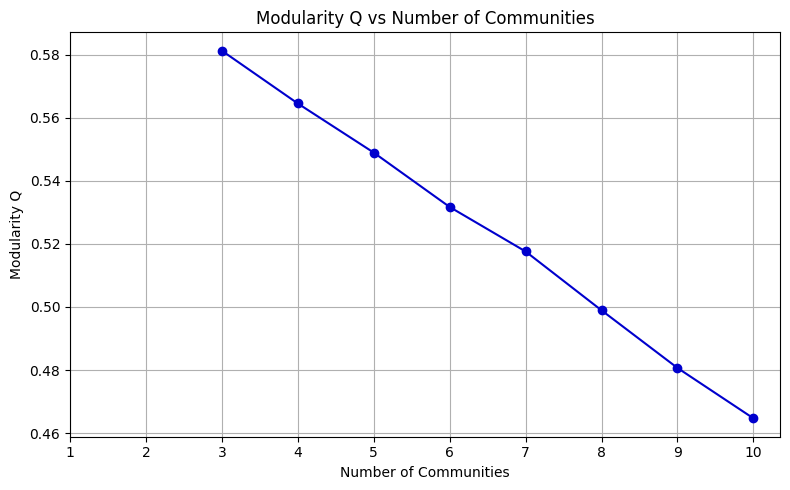

In [9]:
Q, communities, history = newman_fast_algorithm(G, k)
plot_modularity_progress(history, max_comms=10)

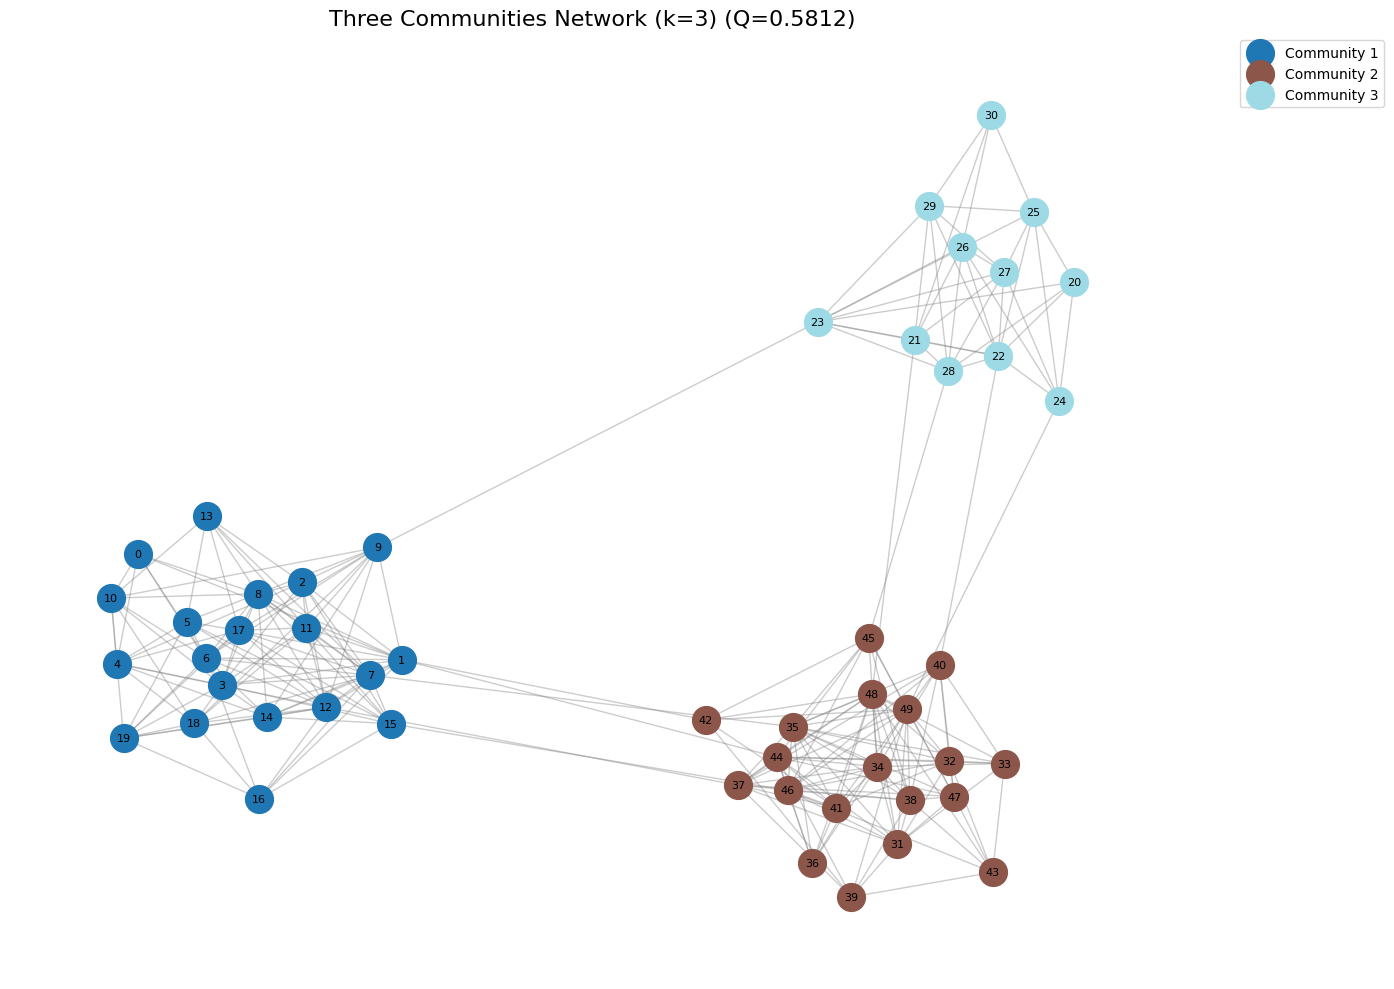

In [10]:
plot_communities(G, communities, inv_mapping, Q, f"Three Communities Network (k={k})")

In [11]:
print(f"\n--- Result for {file_path} with k = {k} ---")
print(f"Modularity Q: {Q:.10f}\n")
print("Communities:")
for i, c in enumerate(communities):
    print(f" Community {i+1}: {sorted(c)}")
print("\n")
print(" ".join(f"({','.join(map(str, sorted(c)))})" for c in communities))



--- Result for three_communities.edgelist with k = 3 ---
Modularity Q: 0.5812494794

Communities:
 Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21]
 Community 2: [15, 16, 22, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
 Community 3: [23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21) (15,16,22,24,25,36,37,38,39,40,41,42,43,44,45,46,47,48,49) (23,26,27,28,29,30,31,32,33,34,35)


Q = 0.58 -> Since Q > 0.3

It means communities are well-separated in three clean communities where each color represent one community. 

## Second file `karate`

In [12]:
file_path = "karate.edgelist"
k = 2

G_karate, inv_mapping_karate = load_graph(file_path)

Loaded graph from: karate.edgelist
 Nodes: 34, Edges: 78
 Density: 0.1390



 Initial e matrix (34×34):
   Each edge contributes 1/(2m) = 1/156 = 0.006410
   Diagonal: 
   Matrix sum: 1.000000
Initial e sum: 1.000000
Step 10: 24 communities, Q=0.1232, e_sum=1.000000
Step 20: 14 communities, Q=0.2534, e_sum=1.000000
Step 29: 5 communities, Q=0.3628, e_sum=1.000000
Step 30: 4 communities, Q=0.3760, e_sum=1.000000
Step 31: 3 communities, Q=0.3807, e_sum=1.000000
Step 32: 2 communities, Q=0.3718, e_sum=1.000000

Final diagnostics:
  e matrix shape: (2, 2)
  e matrix sum: 1.000000
  e diagonal: [0.43589744 0.43589744]
  a values: [0.5 0.5]
  a^2: [0.25 0.25]
  e_ii - a^2: [0.18589744 0.18589744]
  Final Q: 0.3717948718


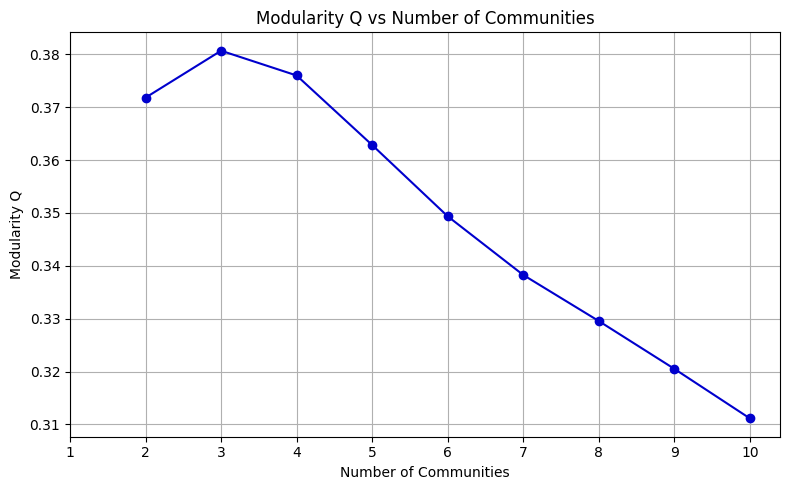

In [13]:
Q_karate, communities_karate, history_karate = newman_fast_algorithm(
    G_karate, k)
plot_modularity_progress(history_karate)

The modularity plot shows that dividing the network into 3 communities gives a stronger community structure than dividing it into just 2, but it is not a major change:

- For 2 communities (k = 2), modularity (Q) = 0.3718

- For 3 communities (k = 3), modularity (Q) = 0.38


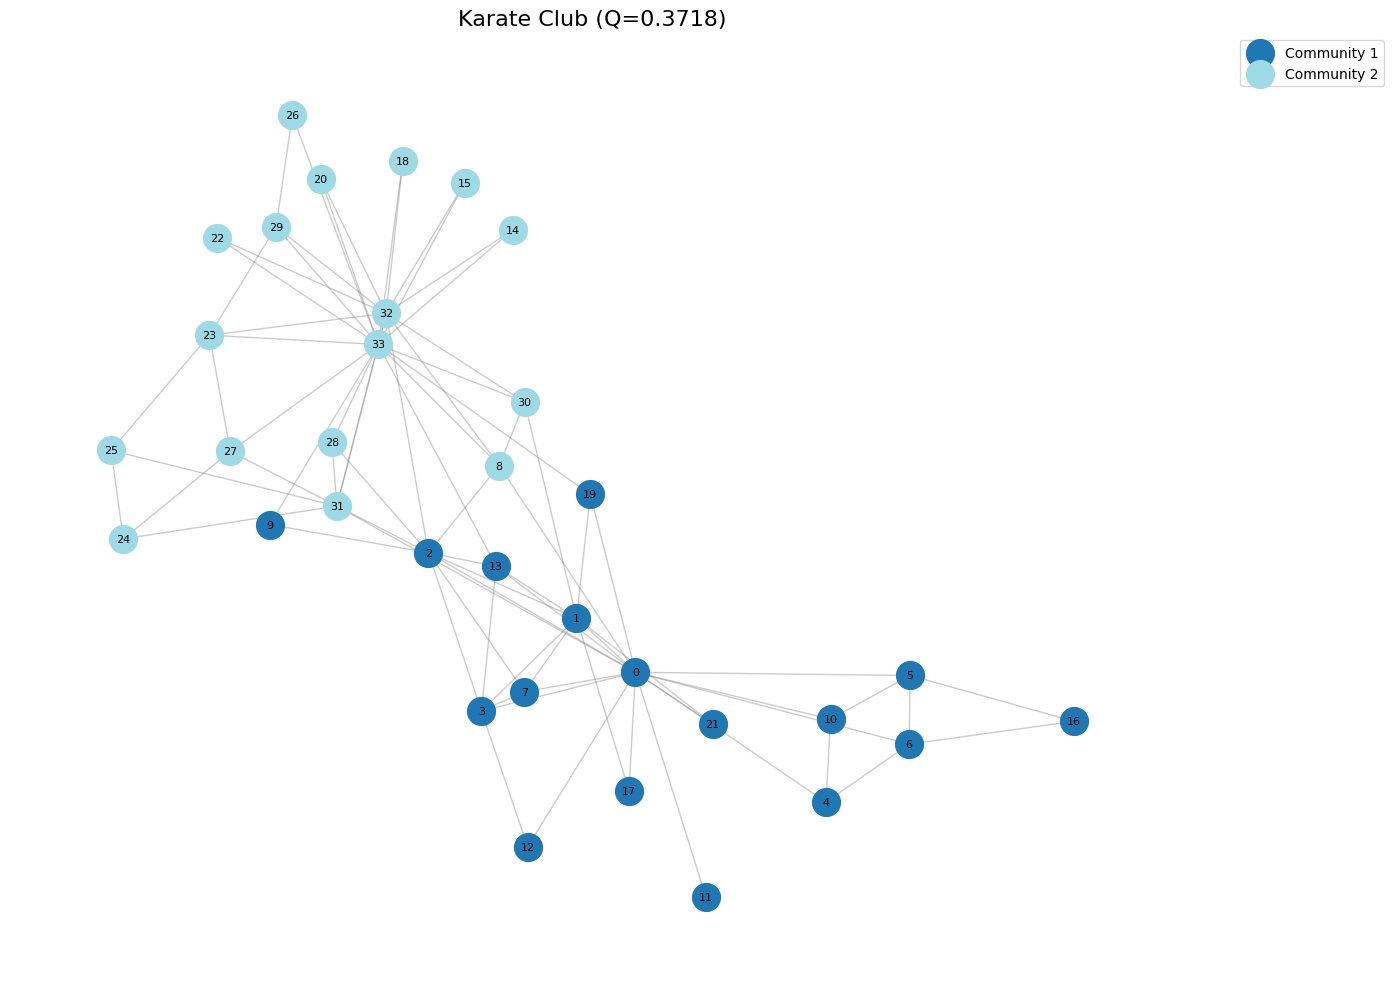

In [14]:
plot_communities(G_karate, communities_karate, inv_mapping_karate, Q_karate, "Karate Club")

In [15]:
print(f"\n--- Result for {file_path} with k = {k} ---")
print(f"Modularity Q: {Q_karate:.10f}\n")
print("Communities:")
for i, c in enumerate(communities_karate):
    print(f" Community {i+1}: {sorted(c)}")
print("\n")
print(" ".join(f"({','.join(map(str, sorted(c)))})" for c in communities_karate))



--- Result for karate.edgelist with k = 2 ---
Modularity Q: 0.3717948718

Communities:
 Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 22]
 Community 2: [8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


(0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,18,22) (8,16,17,19,20,21,23,24,25,26,27,28,29,30,31,32,33)


## The third file `les_miserables`

In [16]:
file_path = "les_miserables.edgelist"
k = 5

G_miserables, inv_mapping_miserables = load_graph(file_path)

Loaded graph from: les_miserables.edgelist
 Nodes: 77, Edges: 254
 Density: 0.0868



 Initial e matrix (77×77):
   Each edge contributes 1/(2m) = 1/508 = 0.001969
   Diagonal: 
   Matrix sum: 1.000000
Initial e sum: 1.000000
Step 10: 67 communities, Q=0.0246, e_sum=1.000000
Step 20: 57 communities, Q=0.1175, e_sum=1.000000
Step 30: 47 communities, Q=0.1755, e_sum=1.000000
Step 40: 37 communities, Q=0.2506, e_sum=1.000000
Step 50: 27 communities, Q=0.3716, e_sum=1.000000
Step 60: 17 communities, Q=0.4688, e_sum=1.000000
Step 70: 7 communities, Q=0.4979, e_sum=1.000000
Step 72: 5 communities, Q=0.5006, e_sum=1.000000

Final diagnostics:
  e matrix shape: (5, 5)
  e matrix sum: 1.000000
  e diagonal: [0.15354331 0.17716535 0.08267717 0.25984252 0.05905512]
  a values: [0.20669291 0.26377953 0.14370079 0.30314961 0.08267717]
  a^2: [0.04272196 0.06957964 0.02064992 0.09189968 0.00683551]
  e_ii - a^2: [0.11082135 0.10758572 0.06202725 0.16794284 0.0522196 ]
  Final Q: 0.5005967512


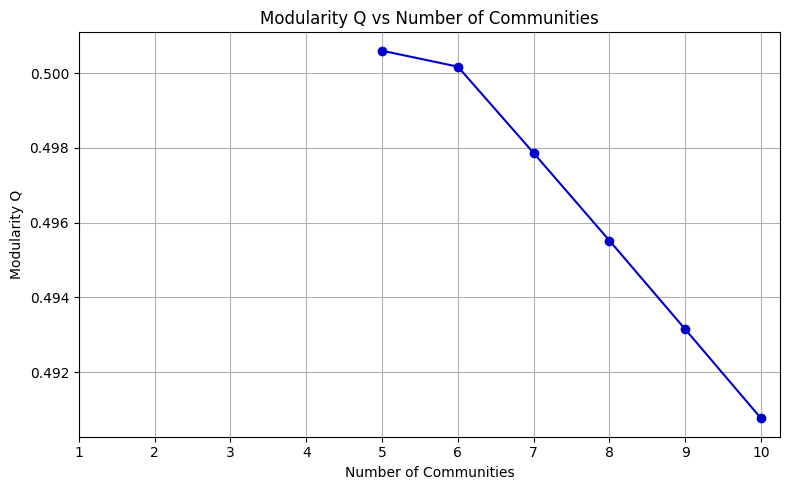

In [17]:
Q_miserables, communities_miserables, history_miserables = newman_fast_algorithm(
    G_miserables, k)
plot_modularity_progress(history_miserables)

Here as well we can see that modularity plot say that we can improve the structure just if we increase the number of communities to *five* but not more because after five it begin dropping. 

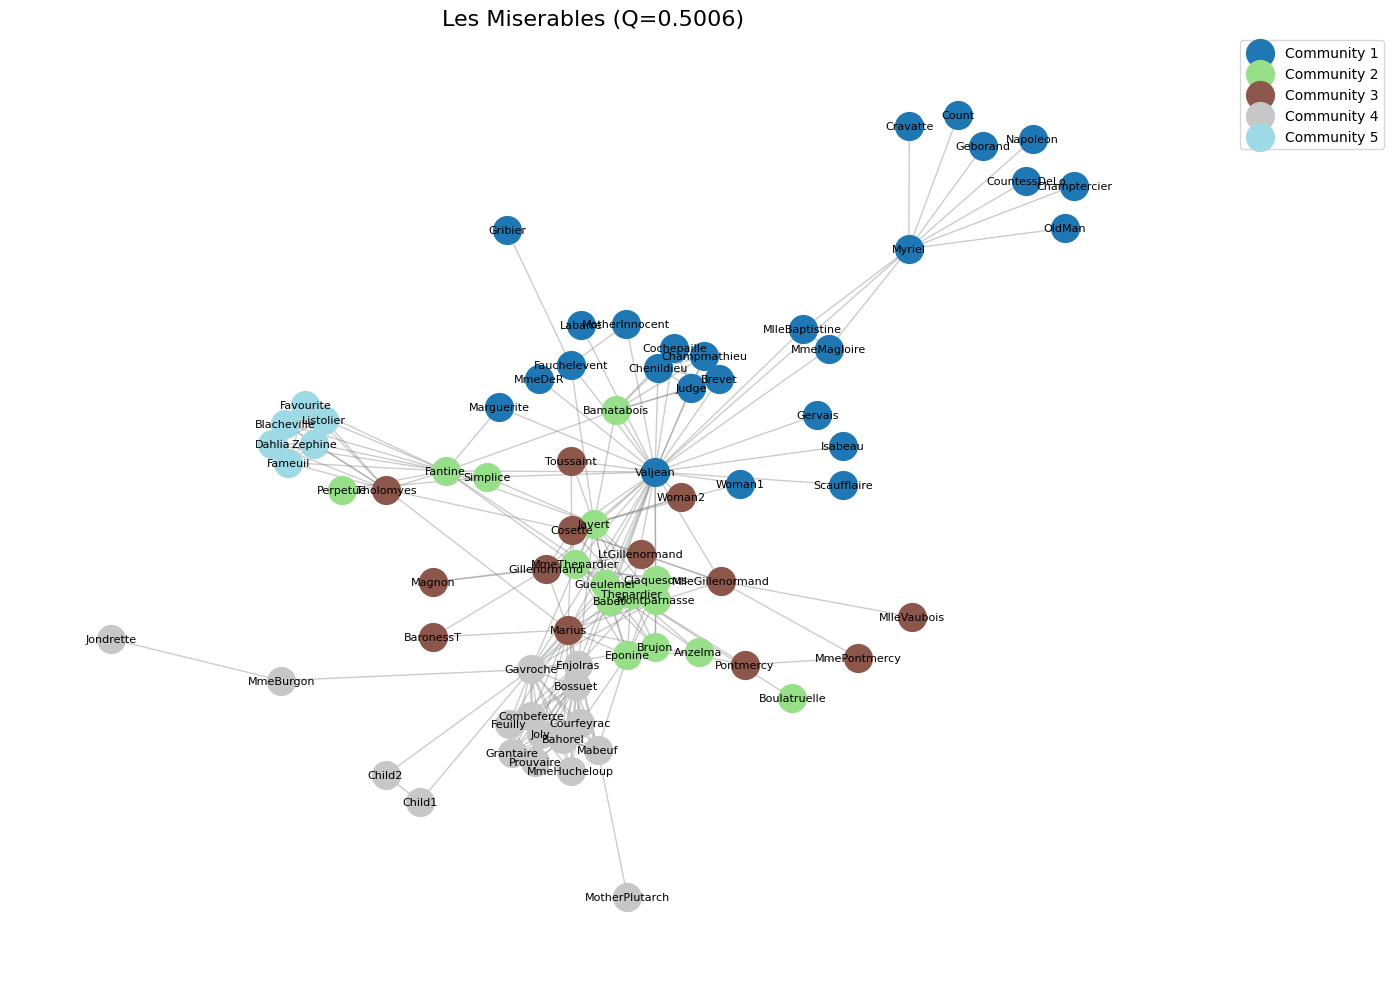

In [18]:
plot_communities(G_miserables, communities_miserables, inv_mapping_miserables, Q_miserables, 
                "Les Miserables")

The Q score is good, but the network itself is complex *communities overlap* no clear structure 


In [19]:
print(f"\n--- Result for {file_path} with k = {k} ---")
print(f"Modularity Q: {Q_miserables:.10f}\n")
print("Communities:")
for i, c in enumerate(communities_miserables):
    print(f" Community {i+1}: {sorted(c)}")
print("\n")
print(" ".join(f"({','.join(map(str, sorted(c)))})" for c in communities_miserables))




--- Result for les_miserables.edgelist with k = 5 ---
Modularity Q: 0.5005967512

Communities:
 Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 24, 25, 26, 27, 28, 29, 30, 32, 59]
 Community 2: [16, 17, 18, 20, 22, 23, 39, 40, 41, 42, 51, 52, 53, 56, 57]
 Community 3: [19, 31, 34, 35, 36, 43, 45, 54, 55, 58, 60, 74, 75]
 Community 4: [33, 37, 38, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76]
 Community 5: [44, 46, 47, 48, 49, 50]


(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,21,24,25,26,27,28,29,30,32,59) (16,17,18,20,22,23,39,40,41,42,51,52,53,56,57) (19,31,34,35,36,43,45,54,55,58,60,74,75) (33,37,38,61,62,63,64,65,66,67,68,69,70,71,72,73,76) (44,46,47,48,49,50)


In [20]:
communities_str = [[inv_mapping_miserables[i] for i in c] for c in communities_miserables]
print("Communities as string:")
for i, c in enumerate(communities_str):
    print(f" Community {i+1}: {sorted(c)}")

final_output_str = " ".join(f"({','.join(map(str, sorted(c)))})" for c in communities_str)
print(f"\n{final_output_str}")

Communities as string:
 Community 1: ['Brevet', 'Champmathieu', 'Champtercier', 'Chenildieu', 'Cochepaille', 'Count', 'CountessDeLo', 'Cravatte', 'Fauchelevent', 'Geborand', 'Gervais', 'Gribier', 'Isabeau', 'Judge', 'Labarre', 'Marguerite', 'MlleBaptistine', 'MmeDeR', 'MmeMagloire', 'MotherInnocent', 'Myriel', 'Napoleon', 'OldMan', 'Scaufflaire', 'Valjean', 'Woman1']
 Community 2: ['Anzelma', 'Babet', 'Bamatabois', 'Boulatruelle', 'Brujon', 'Claquesous', 'Eponine', 'Fantine', 'Gueulemer', 'Javert', 'MmeThenardier', 'Montparnasse', 'Perpetue', 'Simplice', 'Thenardier']
 Community 3: ['BaronessT', 'Cosette', 'Gillenormand', 'LtGillenormand', 'Magnon', 'Marius', 'MlleGillenormand', 'MlleVaubois', 'MmePontmercy', 'Pontmercy', 'Tholomyes', 'Toussaint', 'Woman2']
 Community 4: ['Bahorel', 'Bossuet', 'Child1', 'Child2', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Grantaire', 'Joly', 'Jondrette', 'Mabeuf', 'MmeBurgon', 'MmeHucheloup', 'MotherPlutarch', 'Prouvaire']
 Communi